# Módulos e Configurações

In [28]:
from random import random, randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings, os, random
from math import *
from datetime import datetime

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Modelo Cinemático

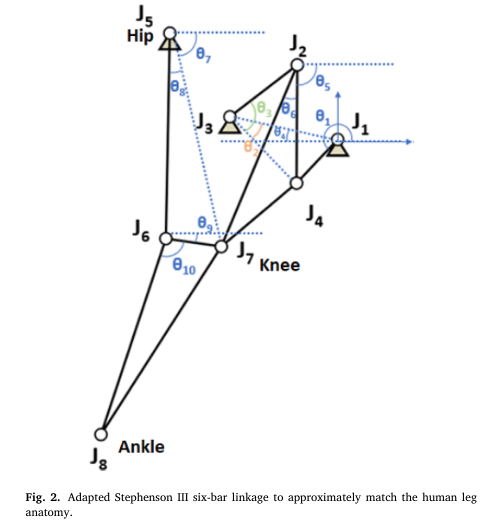

In [50]:
def both_intersections(x0, y0, r0, x1, y1, r1):
    d = np.hypot(x1 - x0, y1 - y0)
    if d > (r0 + r1) or d < abs(r0 - r1) or d == 0:
        return np.array([[np.nan, np.nan], [np.nan, np.nan]])
    a = (r0**2 - r1**2 + d**2) / (2 * d)
    h_sq = r0**2 - a**2
    if h_sq < 0:   # numeriquice
        h_sq = 0.0
    h = np.sqrt(h_sq)
    x2 = x0 + a * (x1 - x0) / d
    y2 = y0 + a * (y1 - y0) / d
    rx = -(y1 - y0) * (h / d)
    ry =  (x1 - x0) * (h / d)
    xi1, yi1 = x2 + rx, y2 + ry
    xi2, yi2 = x2 - rx, y2 - ry
    return np.array([[xi1, yi1], [xi2, yi2]])

def compute_joint_coordinate(params, theta1):
    L56, L68, L87, L67, L32, L27, L24, L47, L14, J1x, J1y, J3x, J3y, J5x, J5y, theta = params

    theta1 = (theta1 + theta) % (2*np.pi)

    # J4
    J4x = J1x + L14 * np.cos(theta1)
    J4y = J1y + L14 * np.sin(theta1)

    # J2
    options = both_intersections(J3x, J3y, L32, J4x, J4y, L24)
    theta1_13 = theta1 + np.arctan2(J1y - J3y, J1x - J3x)

    if np.isnan(options).any():
        return [np.nan]*8

    if theta1_13 > 0:
        J2x, J2y = options[options[:,1].argmax()]
    else:
        J2x, J2y = options[options[:,1].argmin()]

    # J7
    options = both_intersections(J4x, J4y, L47, J2x, J2y, L27)
    J7x, J7y = options[options[:,1].argmin()]

    # J6
    options = both_intersections(J5x, J5y, L56, J7x, J7y, L67)
    J6x, J6y = options[options[:,0].argmin()]

    # J8
    options = both_intersections(J6x, J6y, L68, J7x, J7y, L87)
    J8x, J8y = options[options[:,1].argmin()]

    return [J2x, J2y, J4x, J4y, J6x, J6y, J7x, J7y, J8x, J8y]

def compute_trajectory_deterministic(params, n_points=100):
    global last_config
    L56, L68, L87, L67, L32, L27, L24, L47, L14, J1x, J1y, J3x, J3y, J5x, J5y, theta = params

    theta1_vals = np.linspace(0, 2*np.pi, n_points, endpoint=False)
    theta1_vals = (theta1_vals + theta) % (2*np.pi)

    J7_traj = []
    J8_traj = []

    for theta1 in theta1_vals:

        J2x, J2y, J4x, J4y, J6x, J6y, J7x, J7y, J8x, J8y = compute_joint_coordinate(params, theta1)

        J7_traj.append([J7x, J7y])
        J8_traj.append([J8x, J8y])

    last_config = {
        'J1': (J1x, J1y),
        'J2': (J2x, J2y),
        'J3': (J3x, J3y),
        'J4': (J4x, J4y),
        'J5': (J5x, J5y),
        'J6': (J6x, J6y),
        'J7': (J7x, J7y),
        'J8': (J8x, J8y),
    }

    J7_traj = np.array(J7_traj)
    J8_traj = np.array(J8_traj)
    return np.hstack([J7_traj, J8_traj])

# Algoritmo Genético

## Parâmetros

In [30]:
pop_size       = 500
num_generations= 1000000000000
mutation_rate  = 0.3
elite_rate     = 0.1
num_immigrants  = pop_size//10
N = 100

## Limites

In [31]:
BOUNDS = np.array([
    [0.01, 2],  # L56
    [0.01, 2],  # L68
    [0.01, 2],  # L87
    [0.01, 2],  # L67
    [0.01, 2],  # L32
    [0.01, 2],  # L27
    [0.01, 2],  # L24
    [0.01, 2],  # L47
    [0.01, 2],  # L14
    [-0.5, 0.5],  # J1x
    [-0.5, 0.5],  # J1y
    [-0.5, 0.5],  # J3x
    [-0.5, 0.5],  # J3y
    [0, 0],  # J5x
    [0, 0],  # J5y
    [0, 2*np.pi]])

## Cromossomo

In [32]:
def random_solution():
    lo, hi = BOUNDS[:,0], BOUNDS[:,1]
    return lo + np.random.rand(len(BOUNDS))*(hi-lo)

## Trajetória Alvo

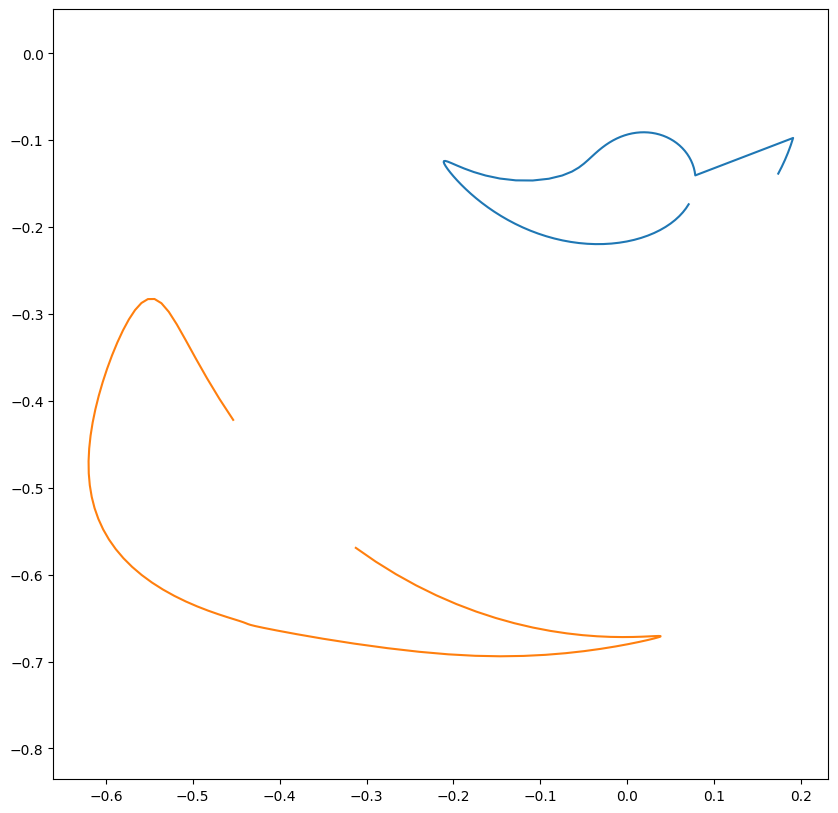

In [33]:
mode = 'replica'  # 'random' or 'file'

if mode == 'random':
    while True:
        target_traj = compute_trajectory_deterministic(random_solution())
        ends_distance = sqrt((target_traj[0,0]-target_traj[-1,0])**2 + (target_traj[0,1]-target_traj[-1,1])**2 + (target_traj[0,2]-target_traj[-1,2])**2 + (target_traj[0,3]-target_traj[-1,3])**2)
        if not np.isnan(target_traj).any():
            break
elif mode == 'file':
    target_traj = np.loadtxt('traj.txt')
    if len(target_traj) != N:
        idx = np.linspace(0, len(target_traj)-1, N)
        target_traj = np.vstack([
            np.interp(idx, np.arange(len(target_traj)), target_traj[:,i])
            for i in range(target_traj.shape[1])
        ]).T
        
    delta = target_traj[-1] - target_traj[0]
    if not np.allclose(delta, 0):
        t_frac = np.linspace(0, 1, len(target_traj))[:, None]  # shape (N,1)
        target_traj = target_traj - t_frac * delta
elif mode == 'replica':
    replica = [0.371, 0.529, 0.580, 0.092, 0.087, 0.277, 0.150, 0.169, 0.077, 0, 0, -0.133, 0.0506, -0.171, 0.203, 0]
    target_traj = compute_trajectory_deterministic(replica)
    
plt.figure(figsize=(10,10))
plt.plot(target_traj[:,0], target_traj[:,1], label='Knee (J7)')
plt.plot(target_traj[:,2], target_traj[:,3], label='Ankle (J8)')
plt.axis('equal')
plt.show()

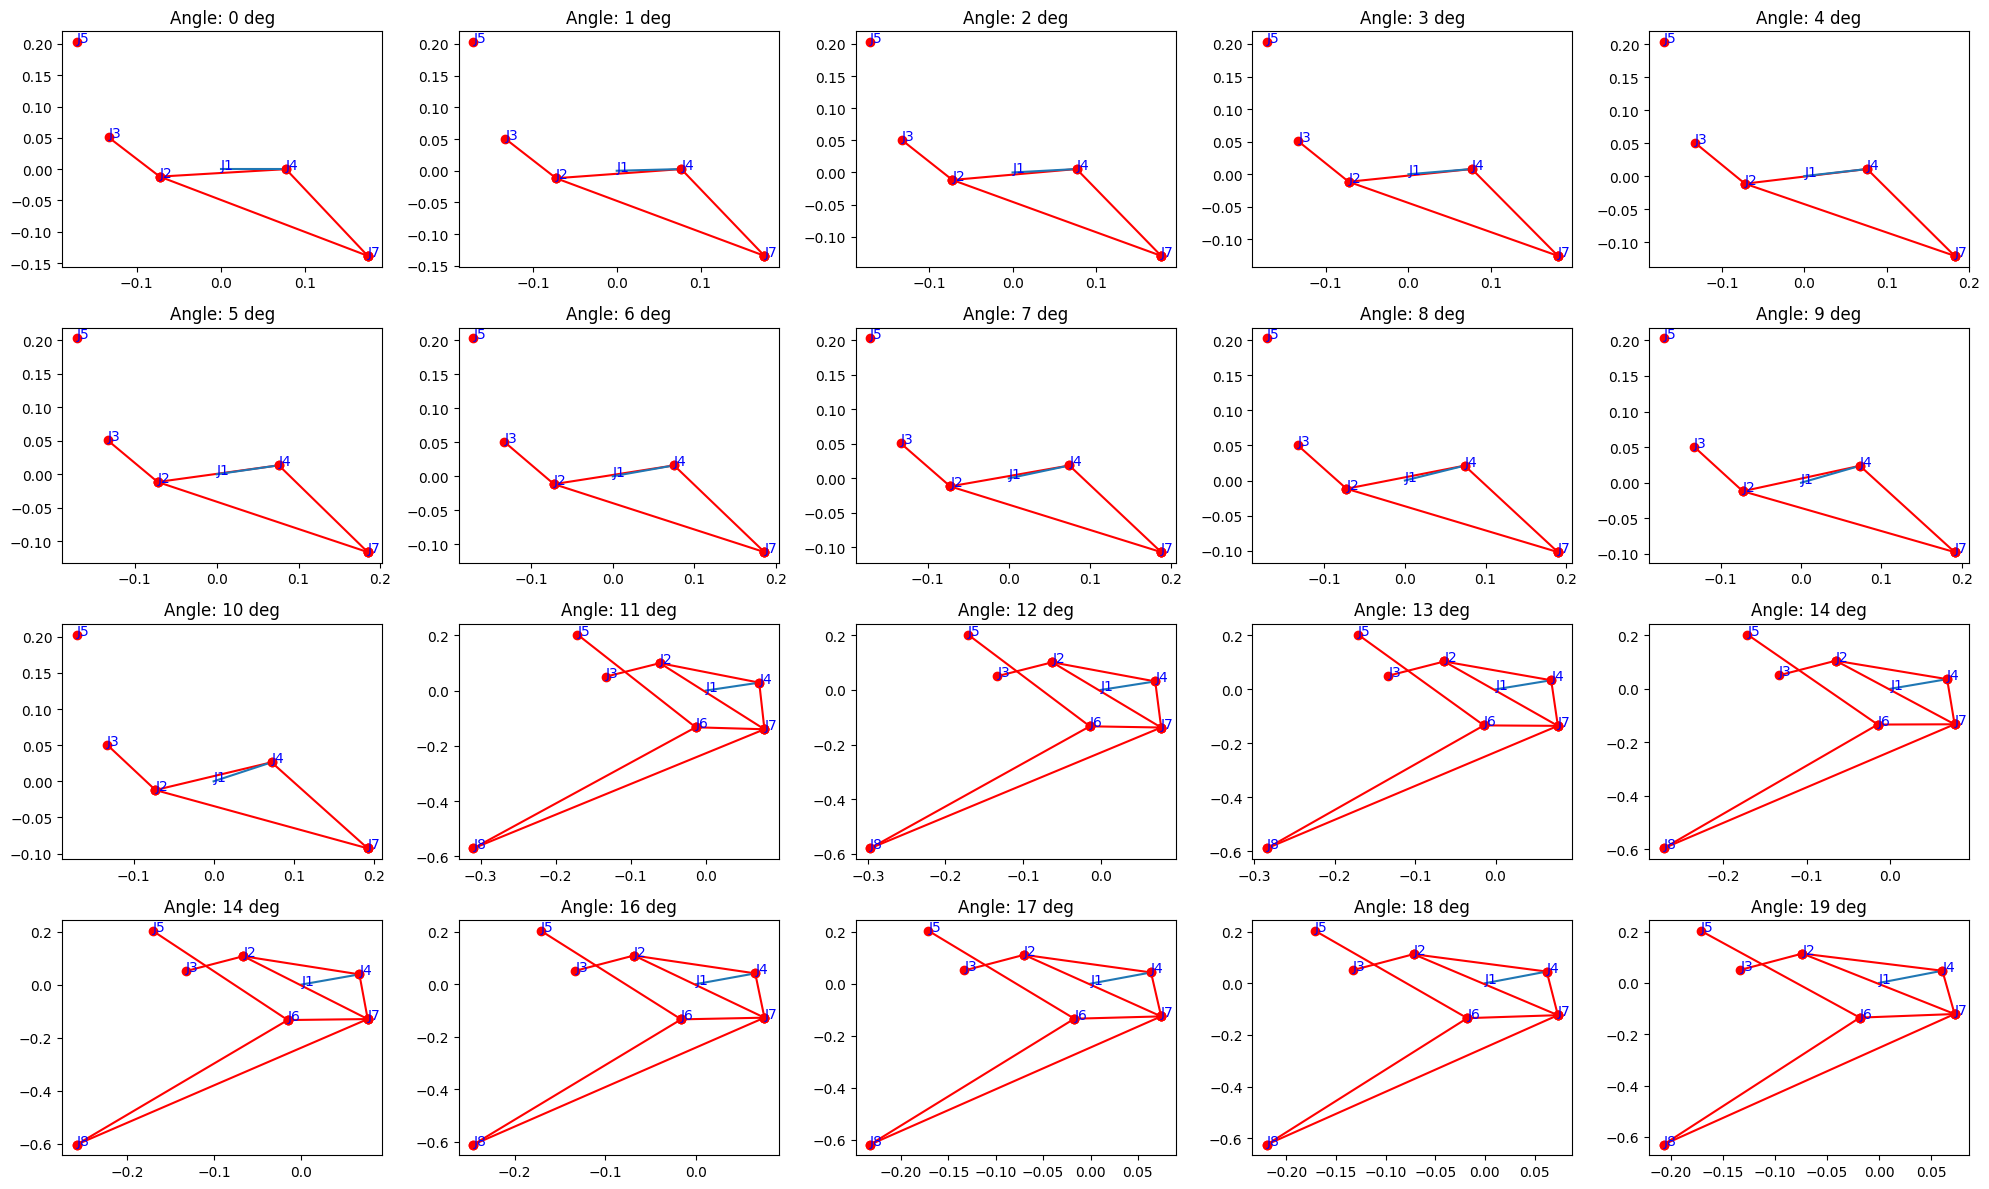

In [55]:
J1x, J1y = replica[9], replica[10]
J3x, J3y = replica[11], replica[12]
J5x, J5y = replica[13], replica[14]

angles = np.linspace(0, np.radians(20), 20, endpoint=False)
cols = 5
rows = int(np.ceil(len(angles)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
axes = axes.flatten()

for i, angle in enumerate(np.linspace(0, np.radians(20), 20, endpoint=False)):
    params = replica.copy()
    params[-1] = angle
    J2x, J2y, J4x, J4y, J6x, J6y, J7x, J7y, J8x, J8y = compute_joint_coordinate(params, angle)
    ax = axes[i]

    ax.plot([J5x, J6x], [J5y, J6y], 'ro-')
    ax.plot([J6x, J8x], [J6y, J8y], 'ro-')
    ax.plot([J7x, J8x], [J7y, J8y], 'ro-')
    ax.plot([J6x, J7x], [J6y, J7y], 'ro-')
    ax.plot([J3x, J2x], [J3y, J2y], 'ro-')
    ax.plot([J2x, J4x], [J2y, J4y], 'ro-')
    ax.plot([J1x, J4x], [J1y, J4y])
    ax.plot([J2x, J7x], [J2y, J7y], 'ro-')
    ax.plot([J4x, J7x], [J4y, J7y], 'ro-')

    # add number to joints
    ax.text(J1x, J1y, 'J1', color='blue')
    ax.text(J2x, J2y, 'J2', color='blue')
    ax.text(J3x, J3y, 'J3', color='blue')
    ax.text(J4x, J4y, 'J4', color='blue')
    ax.text(J5x, J5y, 'J5', color='blue')
    ax.text(J6x, J6y, 'J6', color='blue')
    ax.text(J7x, J7y, 'J7', color='blue')
    ax.text(J8x, J8y, 'J8', color='blue')
    

    # add titles
    ax.set_title(f'Angle: {int(np.degrees(angle))} deg')

plt.tight_layout()

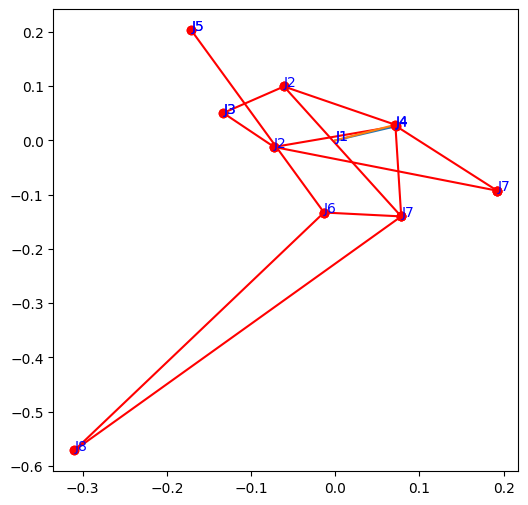

In [58]:
# now in the same axis angles 12° and 13°
fig, ax = plt.subplots(figsize=(6,6))
for angle in np.radians([10,11]):
    params = replica.copy()
    params[-1] = angle
    J2x, J2y, J4x, J4y, J6x, J6y, J7x, J7y, J8x, J8y = compute_joint_coordinate(params, angle)

    ax.plot([J5x, J6x], [J5y, J6y], 'ro-')
    ax.plot([J6x, J8x], [J6y, J8y], 'ro-')
    ax.plot([J7x, J8x], [J7y, J8y], 'ro-')
    ax.plot([J6x, J7x], [J6y, J7y], 'ro-')
    ax.plot([J3x, J2x], [J3y, J2y], 'ro-')
    ax.plot([J2x, J4x], [J2y, J4y], 'ro-')
    ax.plot([J1x, J4x], [J1y, J4y])
    ax.plot([J2x, J7x], [J2y, J7y], 'ro-')
    ax.plot([J4x, J7x], [J4y, J7y], 'ro-')

    # add number to joints
    ax.text(J1x, J1y, 'J1', color='blue')
    ax.text(J2x, J2y, 'J2', color='blue')
    ax.text(J3x, J3y, 'J3', color='blue')
    ax.text(J4x, J4y, 'J4', color='blue')
    ax.text(J5x, J5y, 'J5', color='blue')
    ax.text(J6x, J6y, 'J6', color='blue')
    ax.text(J7x, J7y, 'J7', color='blue')
    ax.text(J8x, J8y, 'J8', color='blue')

## Operadores

## Fitness

In [7]:
def fitness(individual, target_traj):
    score = 0
    traj = compute_trajectory_deterministic(individual)

    # hip above other anchors, ankle below everything
    J1x, J1y = last_config['J1']
    J3x, J3y = last_config['J3']
    J5x, J5y = last_config['J5']
    J6x, J6y = last_config['J6']
    J7x, J7y = last_config['J7']
    J8x, J8y = last_config['J8']
    if J5y < J3y:
        score += 10
    if J5y < J1y:
        score += 10
    if J8y > J1y or J8y > J3y or J8y > J5y or J8y > J7y or J8y > J6y:
        score += 10
    
    if np.isnan(traj).any():
        return float(1e9)
    else:
        traj = (traj - target_traj)**2
        traj = np.sqrt(traj[:,0] + traj[:,1]) + np.sqrt(traj[:,2] + traj[:,3])
        score += traj.sum()
        return score

## Outros Operadores

In [8]:
def tournament_selection(pop, scores, k=3):
    selected = randint(0, len(pop)-1)
    for _ in range(k-1):
        i = randint(0, len(pop)-1)
        if scores[i] < scores[selected]:
            selected = i
    return pop[selected]



ANG_IDX = -1
TWO_PI = 2*np.pi

def crossover_blx(p1, p2, alpha=0.2):
    lo = np.minimum(p1, p2); hi = np.maximum(p1, p2)
    span = hi - lo
    c_lo = lo - alpha*span; c_hi = hi + alpha*span
    c1 = np.random.uniform(c_lo, c_hi)
    c2 = np.random.uniform(c_lo, c_hi)
    # clip + wrap do ângulo
    c1 = np.clip(c1, BOUNDS[:,0], BOUNDS[:,1])
    c2 = np.clip(c2, BOUNDS[:,0], BOUNDS[:,1])
    c1[ANG_IDX] = c1[ANG_IDX] % TWO_PI
    c2[ANG_IDX] = c2[ANG_IDX] % TWO_PI
    return c1, c2

def mutate(ind, sigma0=0.1, sigma_min=0.01, gen=0, gen_max=400):
    sigma = max(sigma_min, sigma0*(1 - gen/gen_max))
    span = BOUNDS[:,1] - BOUNDS[:,0]
    noise = np.random.randn(len(ind)) * (sigma*span)
    mask = np.random.rand(len(ind)) < mutation_rate
    out = ind.copy()
    out[mask] += noise[mask]
    out = np.clip(out, BOUNDS[:,0], BOUNDS[:,1])
    out[ANG_IDX] = out[ANG_IDX] % TWO_PI
    return out


# Execução

In [25]:
population = [random_solution() for _ in range(pop_size)]
best_so_far = float('inf')
best_chromosome = None
stall = 0

In [31]:
run_time = datetime.now().strftime("%Y%m%d_%H%M%S")

for gen in range(num_generations):
    gen += 1
    # avalia população atual
    scores = [fitness(ind, target_traj) for ind in population]
    paired = list(zip(population, scores))
    paired.sort(key=lambda t: t[1])

    # registra melhor da geração corretamente
    gen_best_ind, gen_best_val = paired[0]
    if gen_best_val + 1e-6 < best_so_far:
        best_so_far = gen_best_val
        best_chromosome = gen_best_ind.copy()
        stall = 0
    else:
        stall += 1

    # elites + reprodução
    elites = [p for p,_ in paired[:int(pop_size*elite_rate)]]
    new_pop = elites.copy()
    
    # imigração
    if stall >= 10:
        for _ in range(num_immigrants):
            new_pop.append(random_solution())

    while len(new_pop) < pop_size:
        p1 = tournament_selection(population, scores, k=3)
        p2 = tournament_selection(population, scores, k=3)
        c1, c2 = crossover_blx(p1, p2, alpha=0.2)
        new_pop.append(mutate(c1, gen=gen, gen_max=num_generations))
        if len(new_pop) < pop_size:
            new_pop.append(mutate(c2, gen=gen, gen_max=num_generations))

    population = new_pop
    print(f"Gen {gen}: Best = {best_so_far:.5f}")


Gen 1: Best = 8.01410
Gen 2: Best = 8.01410
Gen 3: Best = 8.01410
Gen 4: Best = 8.01410
Gen 5: Best = 8.01410
Gen 6: Best = 8.01410
Gen 7: Best = 8.01410
Gen 8: Best = 8.01410
Gen 9: Best = 8.01410
Gen 10: Best = 8.01410
Gen 11: Best = 8.01410
Gen 12: Best = 8.01410
Gen 13: Best = 8.01410
Gen 14: Best = 8.01410
Gen 15: Best = 8.01410
Gen 16: Best = 8.01410
Gen 17: Best = 8.01410
Gen 18: Best = 8.01410
Gen 19: Best = 8.01410
Gen 20: Best = 8.01410
Gen 21: Best = 8.01410


KeyboardInterrupt: 

# Resultado

## Melhor Cromossomo

In [9]:
if mode == 'replica':
    best_chromosome = np.array(replica)

d = {
    'L56': best_chromosome[0],  # length
    'L68': best_chromosome[1],  # length
    'L87': best_chromosome[2],  # length
    'L67': best_chromosome[3],  # length
    'L32': best_chromosome[4],  # length
    'L27': best_chromosome[5],  # length
    'L24': best_chromosome[6],  # length
    'L47': best_chromosome[7],  # length
    'L14': best_chromosome[8],  # length
    'J1': f'{best_chromosome[[9,10]]}',  # joint [J1x, J1y]
    'J3': f'{best_chromosome[[11,12]]}', # joint [J3x, J3y]
    'J5': f'{best_chromosome[[13,14]]}',  # joint [J5x, J5y]
    'angle': best_chromosome[15]  # angle parameter
}
BOUNDS = np.array([
    [0.01, 0.5],  # L56
    [0.5, 1],  # L68
    [0.5, 1],  # L87
    [0.01, 0.5],  # L67
    [0.01, 0.5],  # L32
    [0.01, 0.5],  # L27
    [0.01, 0.5],  # L24
    [0.01, 0.5],  # L47
    [0.01, 0.5],  # L14
    [-0.5, 0.5],  # J1x
    [-0.5, 0.5],  # J1y
    [-0.5, 0.5],  # J3x
    [-0.5, 0.5],  # J3y
    [-0.171, -0.171],  # J5x
    [0.203, 0.203],  # J5y
    [0, 2*np.pi]])

d

{'L56': np.float64(0.371),
 'L68': np.float64(0.529),
 'L87': np.float64(0.58),
 'L67': np.float64(0.092),
 'L32': np.float64(0.087),
 'L27': np.float64(0.277),
 'L24': np.float64(0.15),
 'L47': np.float64(0.169),
 'L14': np.float64(0.077),
 'J1': '[0. 0.]',
 'J3': '[-0.133   0.0506]',
 'J5': '[-0.171  0.203]',
 'angle': np.float64(0.0)}

## Gráfico

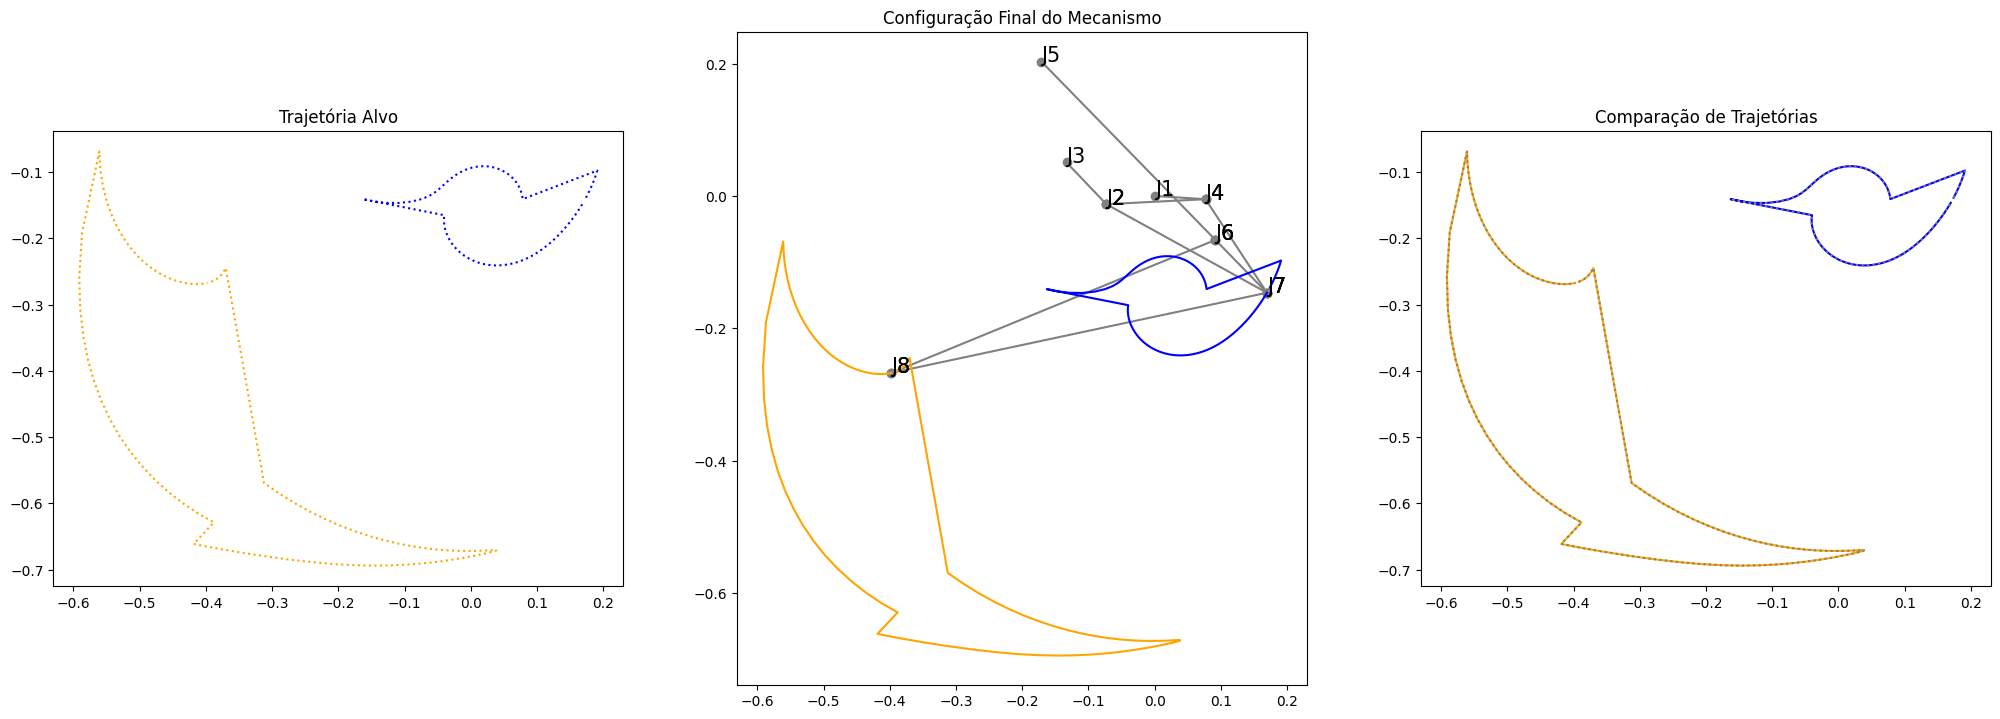

In [10]:
traj = compute_trajectory_deterministic(best_chromosome, n_points=N)

# create 3 columns x 1 row plot
fig, axes = plt.subplots(1, 3, figsize=(25, 10))

# plot target trajectory on the first
axes[0].plot(target_traj[:,0], target_traj[:,1], label='Alvo J7', linestyle='dotted', color='blue')
axes[0].plot(target_traj[:,2], target_traj[:,3], label='Alvo J8', linestyle='dotted', color='orange')
axes[0].set_title('Trajetória Alvo')

# plot mechanism and trajectory on the second
for link in [['J5', 'J6'], ['J6', 'J8'], ['J7', 'J8'], ['J6', 'J7'], ['J3', 'J2'], ['J2', 'J7'], ['J2', 'J4'], ['J4', 'J7'], ['J1', 'J4']]:
    axes[1].plot([last_config[link[0]][0], last_config[link[1]][0]], [last_config[link[0]][1], last_config[link[1]][1]], '-o', color='gray')
    # add label
    axes[1].text(last_config[link[0]][0], last_config[link[0]][1], link[0], fontsize=15)
    axes[1].text(last_config[link[1]][0], last_config[link[1]][1], link[1], fontsize=15)
    
axes[1].plot(traj[:,0], traj[:,1], label='J7', color='blue')
axes[1].plot(traj[:,2], traj[:,3], label='J8', color='orange')
axes[1].set_title('Configuração Final do Mecanismo')

# plot trajectory comparison on the third
axes[2].plot(traj[:,0], traj[:,1], label='J7', color='blue')
axes[2].plot(traj[:,2], traj[:,3], label='J8', color='orange')
axes[2].plot(target_traj[:,0], target_traj[:,1], label='Alvo J7', linestyle='dotted', color='gray')
axes[2].plot(target_traj[:,2], target_traj[:,3], label='Alvo J8', linestyle='dotted', color='gray')
axes[2].set_title('Comparação de Trajetórias')

# set aspect ratio TO EQUAL
for ax in axes:
    ax.set_aspect('equal', adjustable='box')

## Simulador

In [11]:
scalar = 100

J1, J2, J3, J4, J5, J6, J7, J8 = last_config['J1'], last_config['J2'], last_config['J3'], last_config['J4'], last_config['J5'], last_config['J6'], last_config['J7'], last_config['J8']

s = f'''<linkage2>
	<program zoom="1.000000" xoffset="-6" yoffset="0" scalefactor="1.000000" units="Millimeters" backgroundtransparency="0.000000" backgroundscale="1.000000" xgrid="" ygrid=""/>'''

for n, J in enumerate([J1,J2,J3,J4,J5,J6,J7,J8]):
	if J in [J3, J1, J5]:
		print('anchor')
		anchor_condition = "true"
	else:
		anchor_condition = "false"
	s += f'''
	<connector id="{n}" selected="false" layer="16" x="{J[0]*scalar}" y="{J[1]*scalar}" anchor="{anchor_condition}" color="16711680" usercolor="false" name="J{n+1}"/> '''
	if J == J1: # input
		s = s.replace('/>', ' input="true" rpm="15.000000" />')
	# elif J == J7: # output
	# 	s = s.replace('/>', ' draw="true" />')
s = s + '''
	<Link id="0" selected="false" layer="16" linesize="1" shapetype="hull" color="16711680" usercolor="false">
		<connector id="0"/>
	</Link>'''

# links
for a,b in [(5,6),(6,8),(8,7),(6,7),(3,2),(2,7),(2,4),(4,7),(1,4)]:
	s += f'''
	<Link id="{a*10+b}" selected="false" layer="16" linesize="1" shapetype="line" color="16711680" usercolor="false">
		<connector id="{a-1}"/>
		<connector id="{b-1}"/>
	</Link>'''
 
s += '''
	<selected>
	</selected>
	<background></background>
</linkage2>'''

if True:
	with open('4bar.linkage2', 'w') as f:
		f.write(s)
	os.system('taskkill /IM Linkage.exe /F')
	os.startfile('4bar.linkage2')

anchor
anchor
anchor


# Análise do Cálculo da Função Fitness

np.float64(0.0)

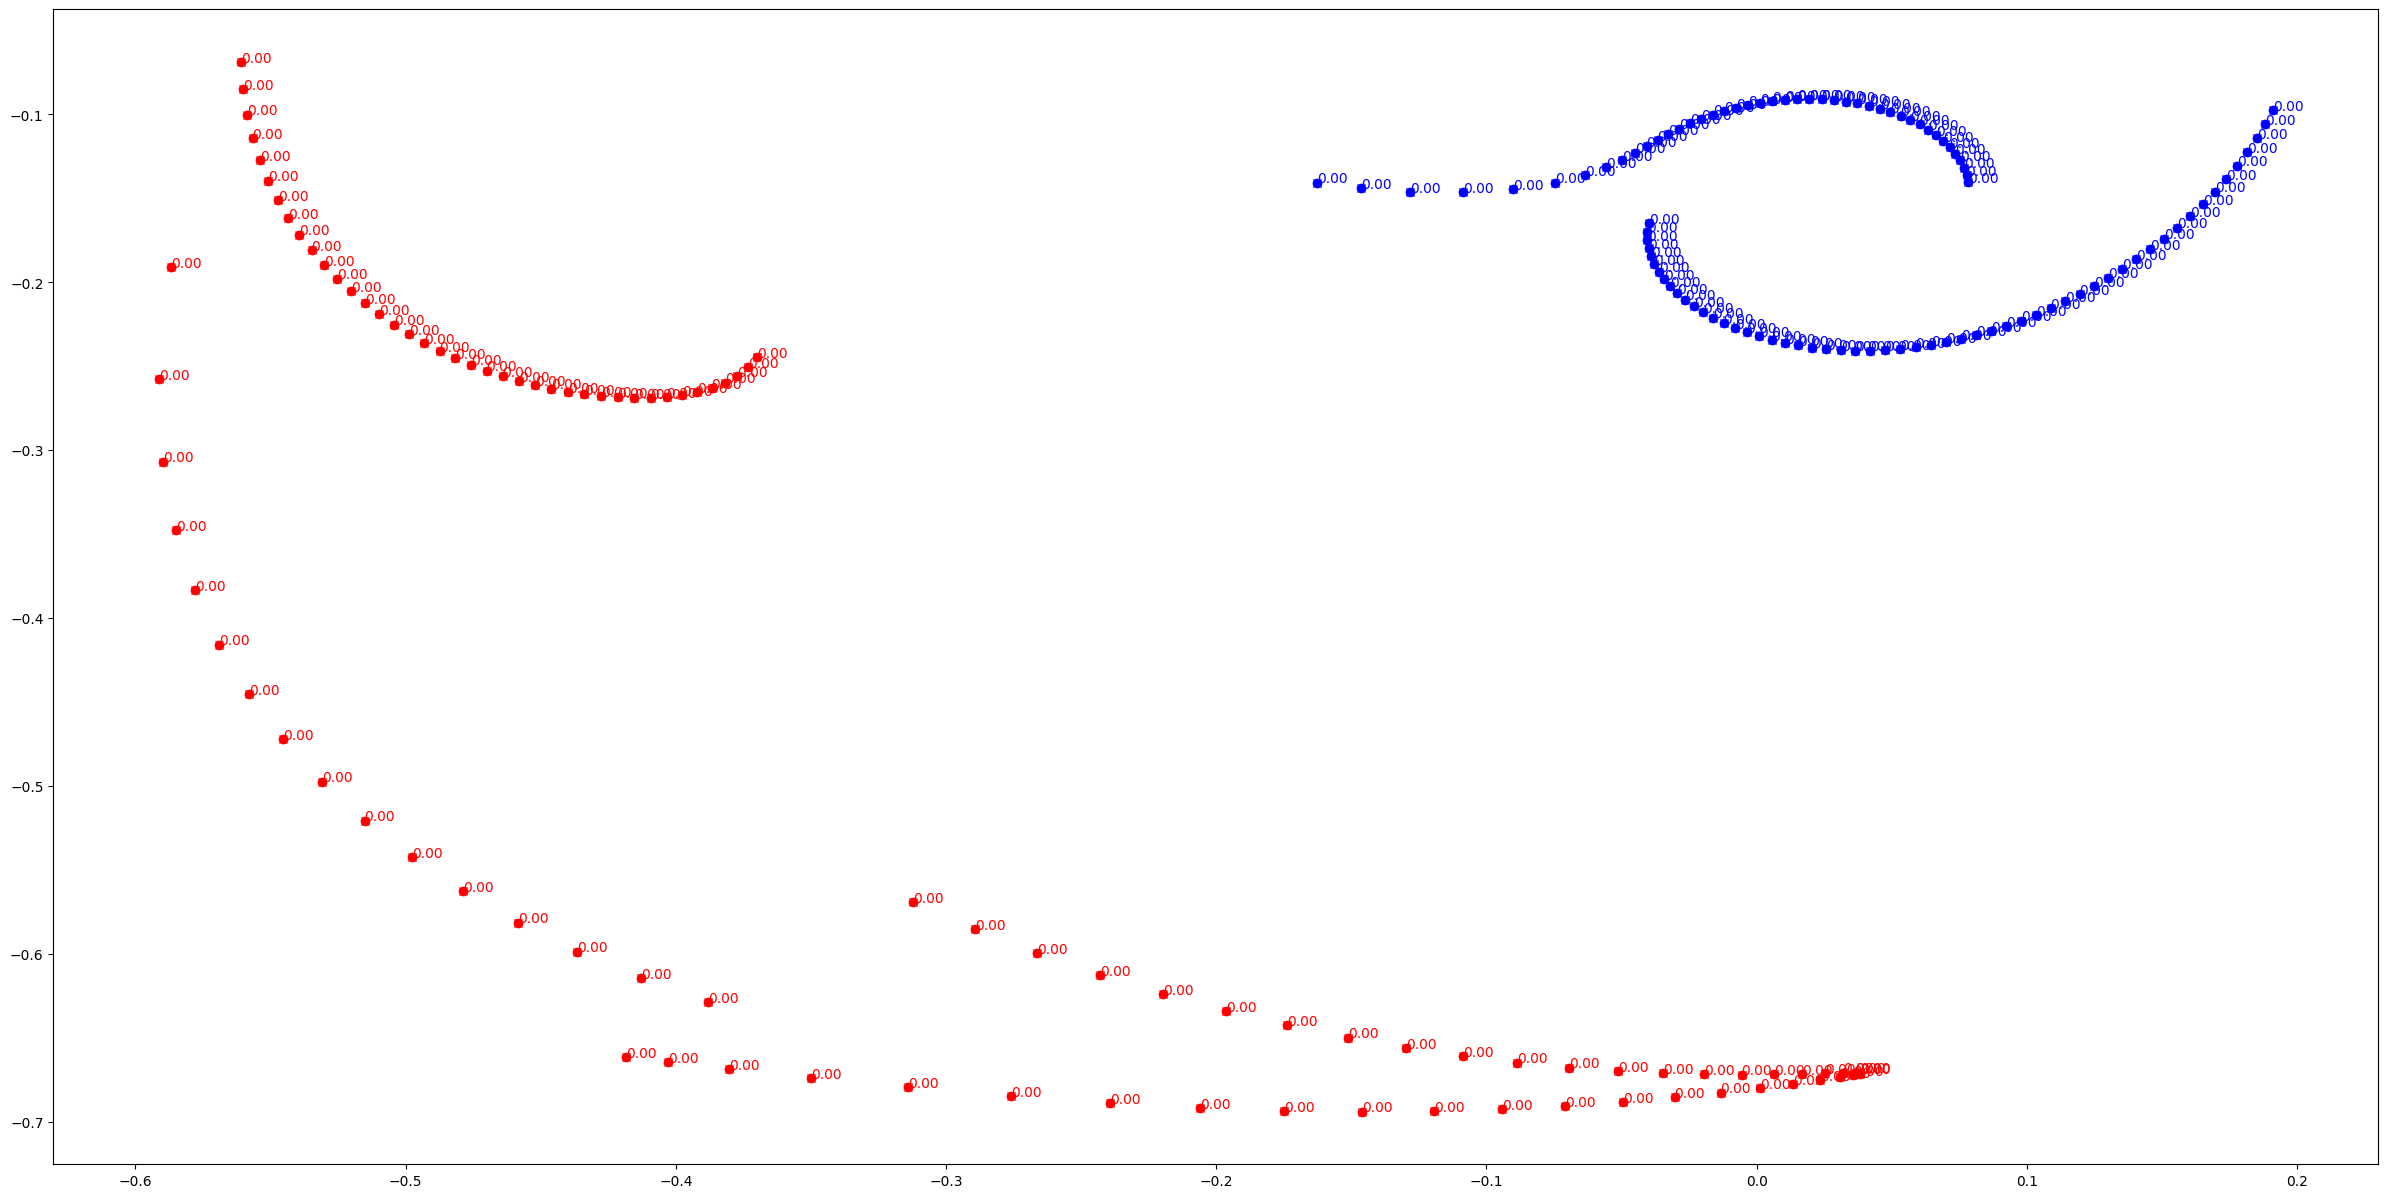

In [12]:
plt.figure(figsize=(30,15))

summed_dist = 0

for p, t in zip(traj, target_traj):
    plt.plot(p[0], p[1], 'bo')
    plt.plot(p[2], p[3], 'ro')

    plt.plot(t[0], t[1], 'bx')
    plt.plot(t[2], t[3], 'rx')

    dist_j7 = np.hypot(p[0]-t[0], p[1]-t[1])
    dist_j8 = np.hypot(p[2]-t[2], p[3]-t[3])

    plt.plot([p[0], t[0]], [p[1], t[1]], 'b--', alpha=0.3)
    plt.plot([p[2], t[2]], [p[3], t[3]], 'r--', alpha=0.3)

    # add text with distance
    plt.text((p[0]+t[0])/2, (p[1]+t[1])/2, f'{dist_j7:.2f}', color='blue')
    plt.text((p[2]+t[2])/2, (p[3]+t[3])/2, f'{dist_j8:.2f}', color='red')

    summed_dist += dist_j7 + dist_j8

summed_dist